In [1]:
#import useful libraries for analysis and modeling
import pandas as pd
import numpy as np
from sklearn import tree
from scipy import stats
import os
import pickle
import sys
import tempfile
# import matplotlib as mpl
# import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score
from sklearn.tree import export_graphviz, DecisionTreeClassifier
pd.options.mode.chained_assignment = None
from IPython.display import display, HTML
import warnings
import json
from matplotlib import cm  # color map
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import shap
# Filter all warnings
warnings.filterwarnings("ignore")


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# # list of 8 applications in dataset
classes = ['Dropcam', 'HP Printer', 'Netatmo Welcome', 'Withings Smart Baby Monitor', 'Netatmo weather station',\
           'Smart Things', 'Amazon Echo', 'Samsung SmartCam','TP-Link Day Night Cloud camera', 'Triby Speaker',\
              'Belkin Wemo switch', 'TP-Link Smart plug', 'PIX-STAR Photo-frame','Belkin wemo motion sensor',\
                     'Samsung Galaxy Tab', 'NEST Protect smoke alarm', 'Withings Smart scale', 'IPhone',\
                            'MacBook', 'Withings Aura smart sleep sensor','Light Bulbs LiFX Smart Bulb',\
                            'Blipcare Blood Pressure meter','iHome', 'Insteon Camera', 'Android Phone', 'Laptop']
classes_df = pd.DataFrame(classes, columns=['class'])

# list of all extracted features
feats_all = ["ip.len","ip.ttl","tcp.flags.syn","tcp.flags.ack","tcp.flags.push","tcp.flags.fin","tcp.flags.rst",\
            "tcp.flags.ece","ip.proto","srcport","dstport","ip.hdr_len","tcp.window_size_value","tcp.hdr_len","udp.length",\
            "Min Packet Length","Max Packet Length","Packet Length Mean","Packet Length Total","UDP Len Min","UDP Len Max",\
                "Flow IAT Min","Flow IAT Max","Flow IAT Mean","Flow Duration",\
                    "SYN Flag Count","ACK Flag Count","PSH Flag Count","FIN Flag Count","RST Flag Count","ECE Flag Count"]

# list of easy to compute online features - without means
feats_easy = ["ip.len","ip.ttl","tcp.flags.syn","tcp.flags.ack","tcp.flags.push","tcp.flags.fin","tcp.flags.rst",\
            "tcp.flags.ece","ip.proto","srcport","dstport","ip.hdr_len","tcp.window_size_value","tcp.hdr_len","udp.length",\
            "Min Packet Length","Max Packet Length","Packet Length Total","UDP Len Min","UDP Len Max",\
                "Flow IAT Min","Flow IAT Max","Flow Duration","SYN Flag Count","ACK Flag Count",\
                    "PSH Flag Count","FIN Flag Count","RST Flag Count","ECE Flag Count"]

feats_no_time = ["ip.len","ip.ttl","tcp.flags.syn","tcp.flags.ack","tcp.flags.push","tcp.flags.fin","tcp.flags.rst",\
            "tcp.flags.ece","ip.proto","srcport","dstport","tcp.window_size_value","tcp.hdr_len","udp.length",\
            "Min Packet Length","Max Packet Length","Packet Length Total",\
                "SYN Flag Count","ACK Flag Count","PSH Flag Count","FIN Flag Count","RST Flag Count","ECE Flag Count"]

In [3]:
""" Function to save trained model to pickle"""
def save_model(RF, filename):
    pickle.dump(RF, open(filename, 'wb'))

def get_test_labels(IoT_Test):
    array_of_indices = []
    unique_labels = IoT_Test["Label"].unique()
    for lab in unique_labels:
        index = classes_df[classes_df['class'] == lab].index.values[0]
        array_of_indices.append(index)
    return unique_labels, array_of_indices

"""
Function to Fit model based on optimal values of depth and number of estimators and use it
to compute feature importance for all the features.
"""
def get_feature_importance(depth, n_tree, max_leaf, X_train, y_train, weight_of_samples,columns):
    
    # rf_opt = RandomForestClassifier(max_depth = depth, n_estimators = n_tree, max_leaf_nodes=max_leaf, random_state=42, bootstrap=False,n_jobs=10)
    rf_opt = RandomForestClassifier(max_depth = depth, n_estimators = n_tree, random_state=42, bootstrap=False,n_jobs=10)
    rf_opt.fit(X_train, y_train, sample_weight=weight_of_samples)
    feature_importance = pd.DataFrame(rf_opt.feature_importances_)
    # feature_importance.index = X_train.columns
    feature_importance.index = columns
    feature_importance = feature_importance.sort_values(by=list(feature_importance.columns),axis=0,ascending=False)
    
    return feature_importance

"""
Function to Fit model based on optimal values of depth and number of estimators and feature importance
to find the fewest possible features to exceed the previously attained score with all selected features
"""
def get_fewest_features(depth, n_tree, max_leaf, importance):    
    sorted_feature_names = importance.index
    # print('sorted_feature_names: ', sorted_feature_names)
    features = []
    for f in range(1,len(sorted_feature_names)+1):
        features.append(sorted_feature_names[0:f])
    return features

def get_result_scores(classes, cl_report):
    precision=[]
    recall=[]
    f1_score=[]
    supports=[]
    for a_class in classes:
        precision.append(cl_report[a_class]['precision'])
        recall.append(cl_report[a_class]['recall'])
        f1_score.append(cl_report[a_class]['f1-score'])
        supports.append(cl_report[a_class]['support'])
    return precision, recall, f1_score, supports


def get_scores(classes, depth, n_tree, feats, max_leaf, X_train, y_train, X_test, y_test, unique_labels,array_of_indices,weight_of_samples):
    model = RandomForestClassifier(max_depth=depth, n_estimators = n_tree, n_jobs=10,
                                    random_state=42, bootstrap=False)
    
    print(model)
    
    model.fit(X_train[feats], y_train, sample_weight=weight_of_samples)
    y_pred = model.predict(X_test[feats])

    y_test = [int(label) for label in y_test.values]
    y_pred = [int(label) for label in y_pred]

    class_report = classification_report(y_test, y_pred, labels=unique_labels, target_names=array_of_indices, output_dict = True)

    macro_score = class_report['macro avg']['f1-score']
    weighted_score = class_report['weighted avg']['f1-score']

    return model, class_report, macro_score, weighted_score, y_pred

def get_model(classes, depth, n_tree, feats, max_leaf, X_train, y_train, X_test, y_test, unique_labels,array_of_indices,weight_of_samples):
    model = RandomForestClassifier(max_depth=depth, n_estimators = n_tree, n_jobs=10,
                                    random_state=42, bootstrap=False)
    
    model.fit(X_train[feats], y_train, sample_weight=weight_of_samples)

    return model

def get_x_y_flow(Dataset, feats):    
    X = Dataset[feats]
    y = Dataset['Label'].replace(classes, range(len(classes)))
    sample_nature = Dataset['sample_nature']
    return X, y, sample_nature

def get_x_y_flow_binary(Dataset, feats):    
    X = Dataset[feats]
    y = Dataset['Label_Binary'].replace(classes, range(len(classes)))
    sample_nature = Dataset['sample_nature']
    return X, y, sample_nature

def expand_rows_and_get_scores(y_true, y_pred, sample_nature, multiply, test_flow_pkt_cnt, test_flow_IDs, unique_labels, array_of_indices):
    expanded_y_true = []
    expanded_y_pred = []
    #
    expanded_weights = []
    expanded_flow_IDs = []
    
    for true_label, pred_label, nature, mult, pkt_cnt, f_id in zip(y_true, y_pred, sample_nature, multiply, test_flow_pkt_cnt, test_flow_IDs):
        if nature == 'flw':
            expanded_y_true.extend([true_label] * (mult+1))
            expanded_y_pred.extend([pred_label] * (mult+1))
            #
            expanded_weights.extend([1/pkt_cnt] * (mult+1))
            expanded_flow_IDs.extend([f_id]* (mult+1))
        else:
            expanded_y_true.append(true_label)
            expanded_y_pred.append(pred_label)
            #
            expanded_weights.append(1/pkt_cnt)
            expanded_flow_IDs.append(f_id)
    
    # report = classification_report(expanded_y_true, expanded_y_pred)
    
    num_samples = len(expanded_y_true)

    expanded_y_true = [int(label) for label in expanded_y_true]
    expanded_y_pred = [int(label) for label in expanded_y_pred]
    # labels=array_of_indices, target_names=unique_labels,
    cl_report_PL = classification_report(expanded_y_true, expanded_y_pred, labels=unique_labels, target_names=array_of_indices, output_dict=True)
    macro_f1_PL = cl_report_PL['macro avg']['f1-score']
    weighted_f1_PL = cl_report_PL['weighted avg']['f1-score']
    try:
        micro_f1_PL = cl_report_PL['micro avg']['f1-score']
    except:
        micro_f1_PL = cl_report_PL['accuracy']
    ####
    
    c_report_FL =  classification_report(expanded_y_true, expanded_y_pred, labels=unique_labels, target_names=array_of_indices, output_dict=True,sample_weight=expanded_weights)
    
    macro_f1_FL = c_report_FL['macro avg']['f1-score']
    weighted_f1_FL = c_report_FL['weighted avg']['f1-score']
    try:
        micro_f1_FL = c_report_FL['micro avg']['f1-score']
    except:
        micro_f1_FL = c_report_FL['accuracy']
    
    return num_samples, macro_f1_PL, weighted_f1_PL, micro_f1_PL, cl_report_PL, macro_f1_FL, weighted_f1_FL, micro_f1_FL, c_report_FL

def compute_flow_pkt_scores(y_pred, y_test, sample_nature,unique_labels,array_of_indices):

    # Create a data frame with the three columns
    df = pd.DataFrame({'y_pred': y_pred, 'y_test': y_test, 'sample_nature': sample_nature})
    
    # Split the data frame into two data frames based on sample_nature
    pkt_df = df[df['sample_nature'] == 'pkt']
    flw_df = df[df['sample_nature'] == 'flw']
    
    # Compute macro and weighted F1 scores for pkt_df
    pkt_df_y_true = [int(label) for label in pkt_df['y_test'].values]
    pkt_df_y_pred = [int(label) for label in pkt_df['y_pred']]

    # labels=array_of_indices, target_names=unique_labels,
    pkt_macro_f1 = classification_report(pkt_df_y_true, pkt_df_y_pred, labels=unique_labels, target_names=array_of_indices, output_dict=True)['macro avg']['f1-score']
    pkt_weighted_f1 = classification_report(pkt_df_y_true, pkt_df_y_pred, labels=unique_labels, target_names=array_of_indices, output_dict=True)['weighted avg']['f1-score']
    
    # Compute macro and weighted F1 scores for flw_df
    flw_df_y_true = [int(label) for label in flw_df['y_test'].values]
    flw_df_y_pred = [int(label) for label in flw_df['y_pred']]

    flw_macro_f1 = classification_report(flw_df_y_true, flw_df_y_pred, labels=unique_labels, target_names=array_of_indices, output_dict=True)['macro avg']['f1-score']
    flw_weighted_f1 = classification_report(flw_df_y_true, flw_df_y_pred, labels=unique_labels, target_names=array_of_indices, output_dict=True)['weighted avg']['f1-score']

    return pkt_macro_f1, pkt_weighted_f1, flw_macro_f1, flw_weighted_f1

In [4]:
# Define a function to check the conditions and assign values
def assign_sample_nature(row):
    if (row["Min Packet Length"] == -1 and
        row["Max Packet Length"] == -1 and
        row["Flow IAT Min"] == -1 and
        row["Flow IAT Max"] == -1):
        return "pkt"
    else:
        return "flw"

In [5]:
threshold_score = 0.99

In [6]:
def convert_str_to_dict(field_value):
    return json.loads(field_value.replace("\'", "\""))

def count_succ_classes(class_list):
    return len(class_list)

### Find the classes having a score > threshold in every model
def find_successful_classes(c_report):
    c_keys = c_report.keys()
    classes_succ = []
    for key in c_keys:
        if key not in ['accuracy', 'macro avg', 'micro avg', 'weighted avg']:
            if c_report[key]['f1-score'] > threshold_score:
                classes_succ.append(key)
    return classes_succ

### Get the score of 3 Classes
def get_score_of_classes(c_report):
    c_keys = c_report.keys()
    for key in c_keys:
        if key == class_name:
            return c_report[key]['f1-score']


In [7]:
def read_csv(csv_file_names):
    csv_files = []
    for f_name in csv_file_names:
        df = pd.read_csv(f_name, sep=';')
        csv_files.append(df)
        
    return pd.concat(csv_files)

In [8]:
def plot_line(x_axis_values, y_axis_values, labels, x_title, y_title, fig_title):
    
# solution_colors = {'Soter': '#6E7E99','Mousika': '#ffbb78', 'Planter': 'teal', 'pForest': '#8A9961', 
                    #    'NetBeacon': '#1f77b4', 'Flowrest': '#E06B5A', 'Jewel': '#A95C68'}
    fig = plt.figure(figsize = (15, 5))
    colors= {'#6E7E99', '#ffbb78','#8A9961','#1f77b4', '#E06B5A', '#A95C68'}
    for x_axis_val, y_axis_val, label, color in zip(x_axis_values, y_axis_values, labels, colors):
        plt.plot(x_axis_val, y_axis_val, label=label, color=color, linewidth=1.5)
    
    plt.xlabel(x_title, fontsize=15, labelpad=13)
    plt.ylabel(y_title, fontsize=15, labelpad=14)
    plt.title(fig_title)
    plt.legend()
    plt.show()

## WITHOUT LIMITATION

#### N=3

In [9]:
file_names_N3 = ['/home/nds-admin/UNSW_PCAPS/hyb_code/with_FL_Metric/model_analysis_results/no_limit_solutions/unsw_models_3pkts_D5-15_T1-20.csv',
                 '/home/nds-admin/UNSW_PCAPS/hyb_code/with_FL_Metric/model_analysis_results/no_limit_solutions/unsw_models_3pkts_D5-19_T21-40.csv',
                 '/home/nds-admin/UNSW_PCAPS/hyb_code/with_FL_Metric/model_analysis_results/no_limit_solutions/unsw_models_3pkts_D15-22_T1-20.csv', 
                 '/home/nds-admin/UNSW_PCAPS/hyb_code/with_FL_Metric/model_analysis_results/no_limit_solutions/unsw_models_3pkts_D20-30_T21-40.csv',
                 '/home/nds-admin/UNSW_PCAPS/hyb_code/with_FL_Metric/model_analysis_results/no_limit_solutions/unsw_models_3pkts_D22-30_T1-20.csv']

In [10]:
model_analysis_noLimit_N3 = read_csv(file_names_N3)

In [11]:
threshold_score = 0.99
model_analysis_noLimit_N3['c_report_FL_99'] = model_analysis_noLimit_N3['cl_report_FL'].apply(convert_str_to_dict)
model_analysis_noLimit_N3['succ_classes_FL_99'] = model_analysis_noLimit_N3['c_report_FL_99'].apply(find_successful_classes)
model_analysis_noLimit_N3['COUNT_succ_classes_FL_99'] = model_analysis_noLimit_N3['succ_classes_FL_99'].apply(count_succ_classes)
#
threshold_score = 0.97
model_analysis_noLimit_N3['c_report_FL_97'] = model_analysis_noLimit_N3['cl_report_FL'].apply(convert_str_to_dict)
model_analysis_noLimit_N3['succ_classes_FL_97'] = model_analysis_noLimit_N3['c_report_FL_97'].apply(find_successful_classes)
model_analysis_noLimit_N3['COUNT_succ_classes_FL_97'] = model_analysis_noLimit_N3['succ_classes_FL_97'].apply(count_succ_classes)
#
threshold_score = 0.95
model_analysis_noLimit_N3['c_report_FL_95'] = model_analysis_noLimit_N3['cl_report_FL'].apply(convert_str_to_dict)
model_analysis_noLimit_N3['succ_classes_FL_95'] = model_analysis_noLimit_N3['c_report_FL_95'].apply(find_successful_classes)
model_analysis_noLimit_N3['COUNT_succ_classes_FL_95'] = model_analysis_noLimit_N3['succ_classes_FL_95'].apply(count_succ_classes)
#
threshold_score = 0.93
model_analysis_noLimit_N3['c_report_FL_93'] = model_analysis_noLimit_N3['cl_report_FL'].apply(convert_str_to_dict)
model_analysis_noLimit_N3['succ_classes_FL_93'] = model_analysis_noLimit_N3['c_report_FL_93'].apply(find_successful_classes)
model_analysis_noLimit_N3['COUNT_succ_classes_FL_93'] = model_analysis_noLimit_N3['succ_classes_FL_93'].apply(count_succ_classes)
###
class_name = 'Light Bulbs LiFX Smart Bulb'
model_analysis_noLimit_N3['score_Light_Bulbs_LiFX_Smart_Bulb'] = model_analysis_noLimit_N3['c_report_FL_99'].apply(get_score_of_classes)
class_name = 'Netatmo weather station'
model_analysis_noLimit_N3['score_Netatmo_Weather_station'] = model_analysis_noLimit_N3['c_report_FL_99'].apply(get_score_of_classes)
class_name = 'Smart Things'
model_analysis_noLimit_N3['score_Smart_Things'] = model_analysis_noLimit_N3['c_report_FL_99'].apply(get_score_of_classes)

In [12]:
model_analysis_3CLasses = model_analysis_noLimit_N3[model_analysis_noLimit_N3['COUNT_succ_classes_FL_99']>2]

In [13]:
# model_analysis_3CLasses.sort_values(by='no_feats').head(15)[['depth','tree','no_feats','feats','score_Light_Bulbs_LiFX_Smart_Bulb','score_Netatmo_Weather_station','score_Smart_Things','Macro_f1_FL','Weighted_f1_FL','Micro_f1_FL']]

#### The scores more than 80%

In [14]:
model_analysis_N3_BEST = model_analysis_noLimit_N3[model_analysis_noLimit_N3['Weighted_f1_FL'] > 0.85].sort_values(by='Weighted_f1_FL', ascending=False).head(3000)

In [15]:
class_occurences = {}
for cl_list in model_analysis_N3_BEST['succ_classes_FL_99'].to_list():
    for cl in cl_list:
        try:
            class_occurences[cl] = class_occurences[cl] + 1
        except:
            class_occurences[cl] = 1
print(class_occurences)

{'Light Bulbs LiFX Smart Bulb': 2998, 'Netatmo weather station': 2727, 'Smart Things': 2992}


In [16]:
# Load Train and Test data
time = "normal"
npkts = 3
feats_to_use = feats_all
if(time=="normal"):
    train_data = pd.read_csv("/home/nds-admin/UNSW_PCAPS/train/train_data_hybrid/train_data_"+str(npkts)+".csv")
    test_data = pd.read_csv("/home/nds-admin/UNSW_PCAPS/test/csv_files/16-10-05.pcap.txt_"+str(npkts)+"_pkts.csv")
#
flow_pkt_counts = pd.read_csv("/home/nds-admin/UNSW_PCAPS/hyb_code/16-10-05-flow-counts.csv")
#
### FIX ###
flow_count_dict = flow_pkt_counts.set_index("flow.id")["count"].to_dict()
# Map the values from flow_pkt_counts to test_data based on the "Flow ID" column
test_data["pkt_count"] = test_data["Flow ID"].map(flow_count_dict)
###########

#### To get packet count of each flow in train data
packet_data = pd.read_csv("/home/nds-admin/UNSW_PCAPS/train/train_data_hybrid/UNSW_train_ALL_PKT_DATE.csv")
packet_data = packet_data[['Flow ID', 'packet_count', 'File']]
packet_data['File_ID'] = packet_data['Flow ID'] + ' ' + packet_data['File']
packet_data = packet_data.drop_duplicates(subset='File_ID', keep='first')
train_data['File_ID'] = train_data['Flow ID'] + ' ' + train_data['File']

flow_count_dict_train = packet_data.set_index("File_ID")["packet_count"].to_dict()
# Map the values from flow_pkt_counts to test_data based on the "Flow ID" column
train_data["pkt_count"] = train_data["File_ID"].map(flow_count_dict_train)
###########

In [17]:
all_minus_one = (test_data['Min Packet Length'] == -1) & (test_data['Max Packet Length'] == -1) & (test_data['Packet Length Mean'] == -1)
# Assign values to the multiply column based on the conditions
test_data['multiply'] = np.where(all_minus_one, 1, test_data['pkt_count'] - npkts)

train_data = train_data.sample(frac=1, random_state=42)
test_data  = test_data.sample(frac=1, random_state=42)

train_data = train_data.dropna(subset=['srcport', 'dstport']) 
test_data  = test_data.dropna(subset=['srcport', 'dstport'])

test_labels, test_indices = get_test_labels(test_data)
print("Num Labels: ", len(test_labels))

train_data['sample_nature'] = train_data.apply(assign_sample_nature, axis=1)
test_data['sample_nature']  = test_data.apply(assign_sample_nature, axis=1)

train_data['weight'] = np.where(train_data['sample_nature'] == 'flw', (train_data['pkt_count'] - npkts + 1)/train_data['pkt_count'], 1/train_data['pkt_count'])
weight_of_samples = list(train_data['weight'])


# Get Variables and Labels
y_multiply = test_data['multiply'].astype(int)
test_flow_pkt_cnt = test_data['pkt_count'].to_list()
test_flow_IDs = test_data['Flow ID'].to_list()
X_train, y_train, sample_nat_train = get_x_y_flow(train_data, feats_to_use)
X_test,  y_test, sample_nat_test  = get_x_y_flow(test_data, feats_to_use)

Num Labels:  24


KeyboardInterrupt: 

In [ ]:
test_data['weight'] = np.where(test_data['sample_nature'] == 'flw', (test_data['pkt_count'] - npkts + 1)/test_data['pkt_count'], 1/test_data['pkt_count'])
weight_of_samples_test = list(test_data['weight'])

In [ ]:
depth = 23
n_tree = 32
no_feats = 15
leaf = 500
feats = model_analysis_N3_BEST[(model_analysis_N3_BEST['depth'] == depth) & (model_analysis_N3_BEST['tree'] == n_tree) & (model_analysis_N3_BEST['no_feats'] == no_feats)]['feats'].to_list()[0].strip('[]').strip('\"\'\"').split('\', \'') 
# print(feats)

In [ ]:
model, c_report, macro_f1, weight_f1, y_pred = get_scores(classes, depth, n_tree, feats, leaf, X_train, y_train, X_test, y_test,  test_indices, test_labels, weight_of_samples)

num_samples, macro_f1_PL, weighted_f1_PL, micro_f1_PL, cl_report_PL, macro_f1_FL, weighted_f1_FL, micro_f1_FL, cl_report_FL = expand_rows_and_get_scores(y_test, y_pred, sample_nat_test, y_multiply, test_flow_pkt_cnt, test_flow_IDs, test_indices, test_labels)                       
print(macro_f1_FL, weighted_f1_FL, micro_f1_FL)


RandomForestClassifier(bootstrap=False, max_depth=23, n_estimators=32,
                       n_jobs=10, random_state=42)
0.7923829498103626 0.9081743142574276 0.9065605200052853


#### Feature Importance with FEATURE PERMUTATION

In [ ]:
### ALL WITH MDI-BASED
rf_opt = RandomForestClassifier(max_depth = depth, n_estimators = n_tree, random_state=42, bootstrap=False,n_jobs=10)
rf_opt.fit(X_train, y_train, sample_weight=weight_of_samples)
feature_importance = pd.DataFrame(rf_opt.feature_importances_)
feature_importance.index = X_train.columns
feature_importance = feature_importance.sort_values(by=list(feature_importance.columns),axis=0,ascending=False)

In [21]:
feature_importance

,0
tcp.window_size_value,0.145196
ip.len,0.139791
udp.length,0.111902
dstport,0.098191
ip.ttl,0.089695
tcp.hdr_len,0.078762
srcport,0.078689
Packet Length Total,0.033369
Packet Length Mean,0.030912
Max Packet Length,0.028277


In [26]:
sum(feature_importance[0].to_list())

1.0000000000000002

In [41]:
### ALL WITH PERMUTATION IMPORTANCE
from sklearn.inspection import permutation_importance
import time
start_time = time.time()
result = permutation_importance(
    rf_opt, X_train, y_train, n_repeats=10, random_state=42, n_jobs=20, sample_weight=weight_of_samples)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")
#
forest_importances = pd.Series(result.importances_mean, index=X_test.columns.to_list())

Elapsed time to compute the importances: 630.884 seconds


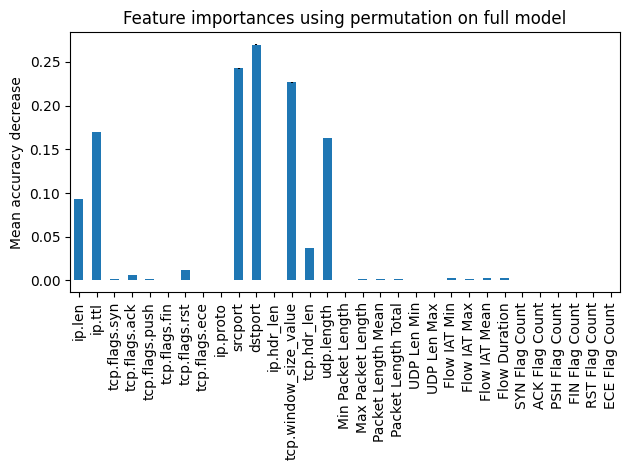

In [45]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

#### PER CLASS

In [18]:
#'Netatmo weather station', 'Smart Things', 'Light Bulbs LiFX Smart Bulb'
classes_3 = ['Light Bulbs LiFX Smart Bulb']

In [107]:
train_data['Label_Binary'] = np.where((train_data['Label'] == classes_3[0]), 1, 0)
#
X_train_3cL,  y_train_3CL, sample_nat_test  = get_x_y_flow_binary(train_data, feats_to_use)
# weight_of_samples_test = list(test_data_1['weight'])
rf_opt = RandomForestClassifier(max_depth = depth, n_estimators = n_tree, random_state=42, bootstrap=False,n_jobs=10)
rf_opt.fit(X_train_3cL, y_train_3CL, sample_weight=weight_of_samples)

RandomForestClassifier(bootstrap=False, max_depth=23, n_estimators=17,
                       n_jobs=10, random_state=42)

In [108]:
# test_data_1 = test_data[test_data['Label'].isin(classes_3)]
# #
# X_test_3cL,  y_test_3CL, sample_nat_test  = get_x_y_flow(test_data_1, feats_to_use)
# weight_of_samples_test = list(test_data_1['weight'])

In [109]:
from sklearn.inspection import permutation_importance
import time
start_time = time.time()
result = permutation_importance(
    rf_opt, X_train_3cL, y_train_3CL, n_repeats=20, random_state=42, n_jobs=25, sample_weight=weight_of_samples
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 245.690 seconds


In [110]:
forest_importances_3CL = pd.Series(result.importances_mean, index=X_train_3cL.columns.to_list())

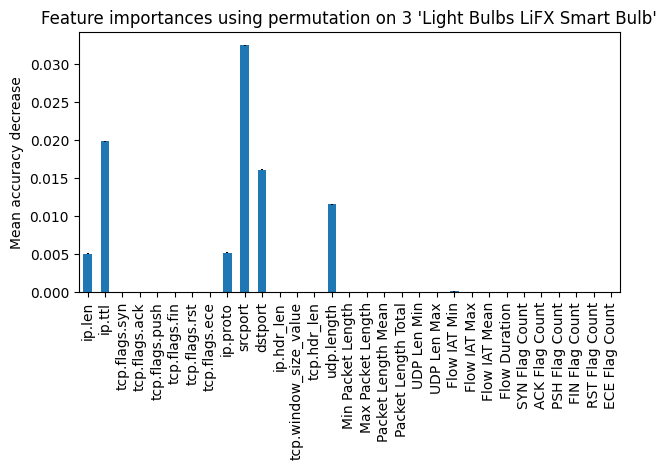

In [114]:
fig, ax = plt.subplots()
forest_importances_3CL.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on 3 'Light Bulbs LiFX Smart Bulb'")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [112]:
rf_opt = RandomForestClassifier(max_depth = depth, n_estimators = n_tree, random_state=42, bootstrap=False,n_jobs=10)
rf_opt.fit(X_train_3cL, y_train_3CL, sample_weight=weight_of_samples)
feature_importance = pd.DataFrame(rf_opt.feature_importances_)
feature_importance.index = X_train.columns
feature_importance = feature_importance.sort_values(by=list(feature_importance.columns),axis=0,ascending=False)

In [113]:
feature_importance

,0
dstport,2.638376e-01
ip.ttl,2.122222e-01
srcport,1.624310e-01
ip.len,1.541308e-01
udp.length,1.331739e-01
ip.proto,1.928185e-02
tcp.hdr_len,1.317057e-02
tcp.flags.ack,8.514415e-03
tcp.window_size_value,6.545128e-03
Flow IAT Min,4.037502e-03


#### SHAP

In [19]:
# !pip3 install fasttreeshap

In [ ]:
from scipy.special import softmax
import fasttreeshap

In [ ]:
### SHAP
rf_opt = RandomForestClassifier(max_depth = depth, n_estimators = n_tree, random_state=42, bootstrap=False, n_jobs=10)
rf_opt.fit(X_train, y_train, sample_weight=weight_of_samples)

RandomForestClassifier(bootstrap=False, max_depth=23, n_estimators=32,
                       n_jobs=10, random_state=42)

In [78]:
y_train[:10].unique()

array([10,  2,  7,  6, 23, 19])

In [ ]:
shap_explainer = fasttreeshap.TreeExplainer(rf_opt, algorithm="auto", n_jobs=-1)

In [ ]:
shap_values = shap_explainer(X_train)

In [25]:
shap_values.shape

(500000, 31, 26)

In [26]:
shap_values.values.shape[1]

31

In [34]:
shap_values.values[:, 1,0]

array([ 0.0034153 ,  0.00491891,  0.0019451 , ..., -0.02254872,
        0.01420355,  0.0043461 ])

In [62]:
shap_values2= shap_values.values

In [126]:
def print_feature_importances_shap_values(shap_values, features):
    '''
    Prints the feature importances based on SHAP values in an ordered way
    shap_values -> The SHAP values calculated from a shap.Explainer object
    features -> The name of the features, on the order presented to the explainer
    '''
    # Calculates the feature importance (mean absolute shap value) for each feature
    importances = []
    importances_norm = []
    for i in range(shap_values.values.shape[1]):  ## Per feature
        importances.append(np.mean(np.abs(shap_values.values[:, i])))
        
    for imp in importances:
        importances_norm.append(imp/sum(importances))
        
    shap_importance_overall = pd.DataFrame({'Features': feats_all, 'importance': importances, 'importance_norm': importances_norm})
    shap_importance_overall = shap_importance_overall.sort_values(by='importance', ascending=False)
    return shap_importance_overall

In [127]:
print_feature_importances_shap_values(shap_values, feats_all)

,Features,importance,importance_norm
12,tcp.window_size_value,0.015534,0.147772
9,srcport,0.011886,0.113067
10,dstport,0.011619,0.110526
13,tcp.hdr_len,0.009440,0.089800
14,udp.length,0.008812,0.083830
1,ip.ttl,0.008754,0.083280
0,ip.len,0.008674,0.082512
6,tcp.flags.rst,0.003090,0.029396
3,tcp.flags.ack,0.002712,0.025803
18,Packet Length Total,0.002515,0.023923


In [128]:
# ## https://christophm.github.io/interpretable-ml-book/shap.html#:~:text=There%20is%20a%20big%20difference,no%20information%20beyond%20the%20importances.
# per_class_importance = []
# per_feature_importance = []
# sample_list_for_feature = []
# for i in range(shap_values.values.shape[1]):
#     sample = shap_values.values[i]
#     importance_per_class = []
#     for cl in range(len(classes)):
#         print(sample[:, cl])
#         importance_per_class.append(np.mean(np.abs(sample[:, cl])))
#         print(importance_per_class)
#         break
#     per_class_importance.append(importance_per_class)
#     break

### PER CLASS

In [129]:
### Get score per class and sort them in descending order
class_names = cl_report_FL.keys()
score_per_class = []
classes_ = []

for c_name in class_names:
    if c_name in classes:
        score_per_class.append(cl_report_FL[c_name]['f1-score'])
        classes_.append(c_name)
    
score_per_class_df = pd.DataFrame({'class': classes_, 'f1_score': score_per_class})
score_per_class_df = score_per_class_df.sort_values(by='f1_score', ascending=False)
score_per_class_df['f1_score'] = score_per_class_df['f1_score']*100

In [130]:
importance_per_class = []
# feat_importance_per_class = pd.DataFrame(columns=['features']+classes)
dict_for_importance_dataframe = {}
dict_for_importance_dataframe_norm = {}
dict_for_importance_dataframe['features'] = feats_all
dict_for_importance_dataframe_norm['features'] = feats_all
classes_ordered = score_per_class_df['class'].to_list()
for c in range(len(classes_ordered)):
    feat_importances = []
    c_name = classes_ordered[c]
    # print(c_name)
    c_original = classes.index(c_name)
    # c_original_2 = list(y_train.unique()).index(c_original)
    # print(c_original)
    # print(c_original_2)
    for f in range(len(feats_all)):
        f_name = feats_all[f]
        # print(f,c)
        # print(shap_values.values[:,f,c])
        feat_importances.append(np.mean(np.abs(shap_values.values[:,f,c_original])))
    dict_for_importance_dataframe[c_name] = feat_importances
    dict_for_importance_dataframe_norm[c_name] = dict_for_importance_dataframe[c_name]/sum(feat_importances)
    importance_per_class.append(feat_importances)
    

In [131]:
feat_importance_per_class_df = pd.DataFrame(dict_for_importance_dataframe)
feat_importance_per_class_df = feat_importance_per_class_df.set_index('features')

In [132]:
feat_importance_per_class_norm_df = pd.DataFrame(dict_for_importance_dataframe_norm)
feat_importance_per_class_norm_df = feat_importance_per_class_norm_df.set_index('features')

In [133]:
sum(feat_importance_per_class_norm_df['Dropcam'].to_list())

1.0000000000000002

In [134]:
import seaborn as sns
import copy as cp

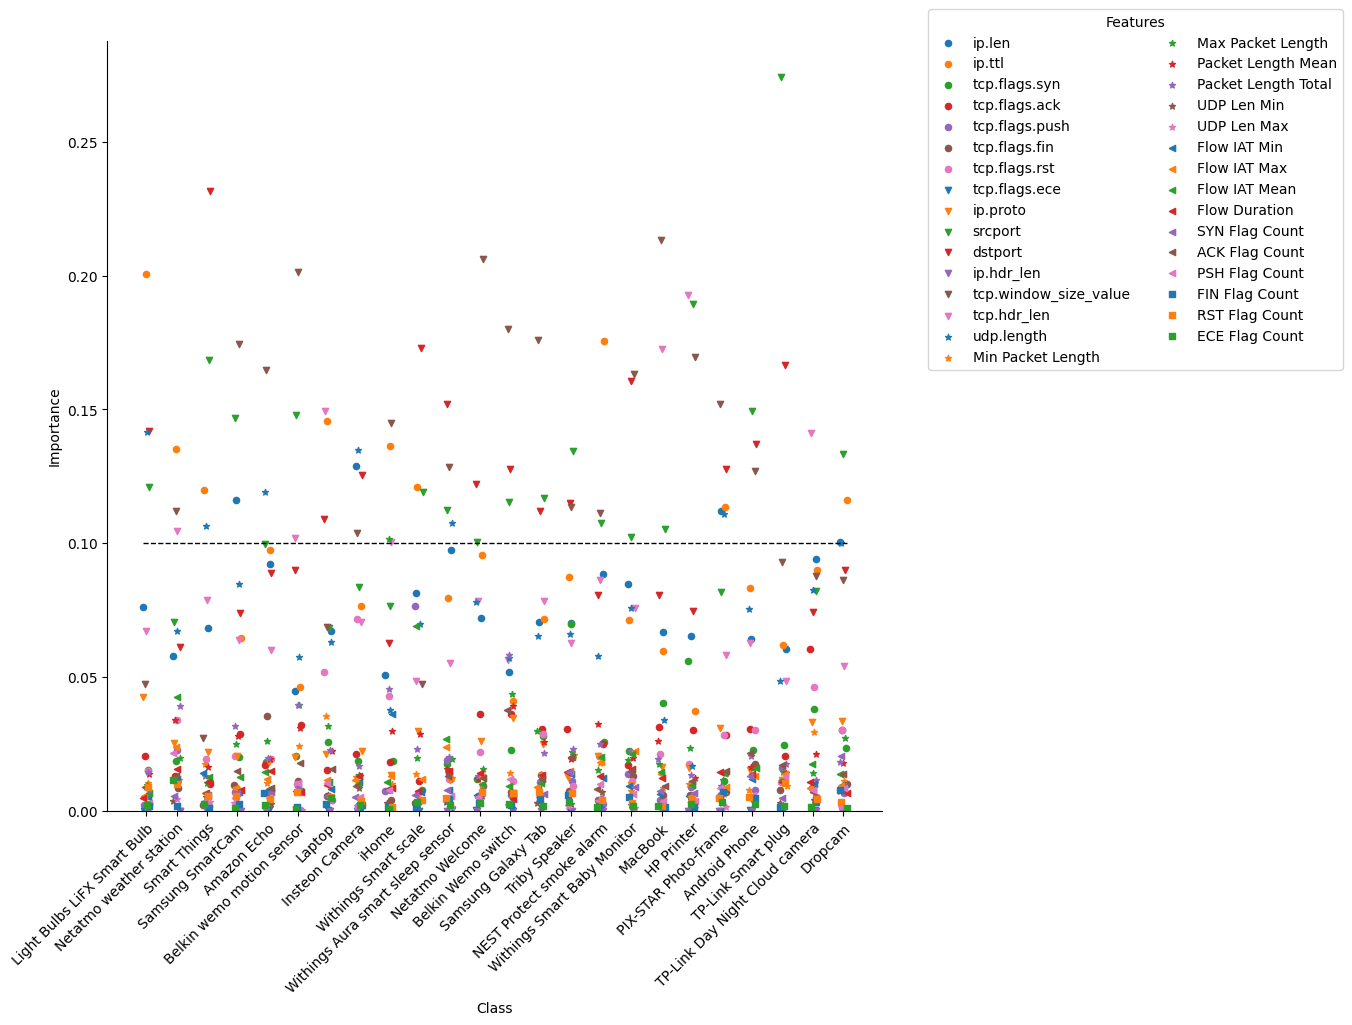

In [135]:
#importance distribution over classes
# imp_mat = calcImportanceMatrix(rf_opt)
marker_lst = [
    "o", "v", "*", "<", ","
]
color_lst = sns.color_palette(n_colors=7)
# print(len(color_lst))
color_marker_lst = [(c,m) for m in marker_lst for c in color_lst]

feature_names = feats_all
class_names = classes_ordered
len_class_names = len(class_names)
# print(class_names)
fig, ax = plt.subplots(figsize=(10,10))
for j in np.arange(len(feature_names)):
    ax.scatter(np.arange(len_class_names) + np.random.uniform(-1,1,size=len_class_names)*.25/2.,
               feat_importance_per_class_norm_df.loc[[feature_names[j]]].values.flatten().tolist(), color=color_marker_lst[j][0], marker=color_marker_lst[j][1],
               s=20, label=feature_names[j])
    # print(imp_mat[:,j])
ax.hlines(y=0.1, xmin=-.25/2., xmax=len(class_names)-1+.25/2., colors='k', linestyles='dashed', lw=1)
ax.legend(bbox_to_anchor=(1.05, 1.05), title='Features', ncol=2)
ax.set_xticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names, rotation=45, ha='right', rotation_mode='anchor')
ax.set_xlabel('Class')
ax.set_ylabel('Importance')
ax.set_ylim(bottom=0)
sns.despine(fig=fig)
#fig.savefig(fig_path+'/feature_importance_distribution_in_classes.pdf', bbox_inches='tight')
plt.show()
plt.close()


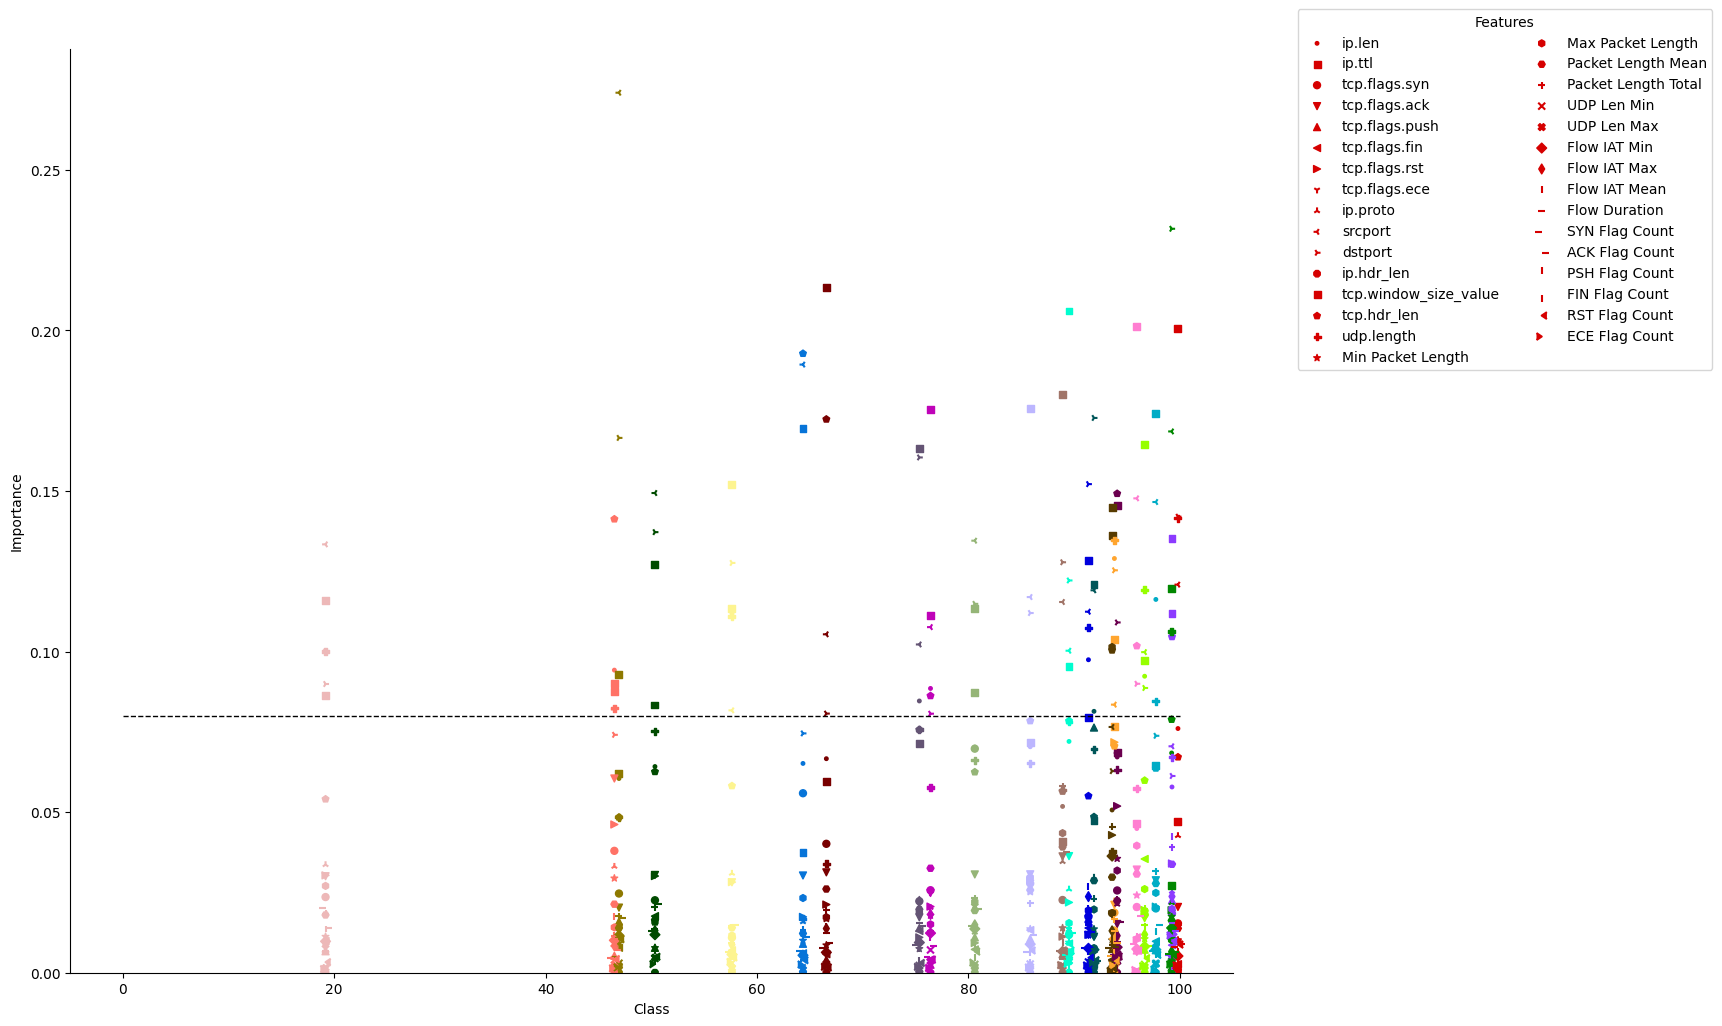

In [136]:
#### CLASS vs IMPORTANCE
## marker: to represent features
import colorcet as cc
marker_lst = [
    ".", ",", "o", "v", "^", "<", ">", "1", "2", "3", "4", "8", "s", "p", "P", "*", "h", "H", "+", "x", "X",
    "D", "d", "|", "_", 0, 1, 2, 3, 4, 5
]
## color: to represent classes
color_lst = sns.color_palette(cc.glasbey, n_colors=24)
color_marker_lst = [(c,m) for m in marker_lst for c in color_lst]
#
feature_names = feats_all
class_names = classes_ordered
len_class_names = len(class_names)
class_scores_ordered = list(score_per_class_df['f1_score'])
#
fig, ax = plt.subplots(figsize=(15,12))
for j in np.arange(len(feature_names)):
    ax.scatter(class_scores_ordered,
               feat_importance_per_class_norm_df.loc[[feature_names[j]]].values.flatten().tolist(), color=color_lst, marker=marker_lst[j],
               s=25, label=feature_names[j])
## plot feature importance threshold
ax.hlines(y=0.08, xmin=-0, xmax=100, colors='k', linestyles='dashed', lw=1)
ax.legend(bbox_to_anchor=(1.05, 1.05), title='Features', ncol=2)
# ax.set_xticks(class_scores_ordered)
# ax.set_xticklabels(class_names, rotation=90, fontsize = 10)
ax.set_xlabel('Class')
ax.set_ylabel('Importance')
ax.set_ylim(bottom=0)
sns.despine(fig=fig)
#fig.savefig(fig_path+'/feature_importance_distribution_in_classes.pdf', bbox_inches='tight')
plt.show()
plt.close()


## PLOT for CLUSTERS

In [137]:
clusters = [['Light Bulbs LiFX Smart Bulb', 'Netatmo weather station', 'Smart Things'],
            ['Samsung SmartCam', 'Amazon Echo', 'Belkin wemo motion sensor'],
            ['Laptop', 'Insteon Camera', 'iHome'],
            ['Withings Smart scale', 'Withings Aura smart sleep sensor'],
            ['Netatmo Welcome', 'Belkin Wemo switch'],
            ['Samsung Galaxy Tab'],
            ['Triby Speaker'],
            ['NEST Protect smoke alarm', 'Withings Smart Baby Monitor'],
            ['MacBook', 'HP Printer'],
            ['PIX-STAR Photo-frame'],
            ['Android Phone', 'TP-Link Smart plug', 'TP-Link Day Night Cloud camera']]

In [138]:
def plot_3d_for_clusters(classes_in_name, classes_in_score, classes_in_indices, class_scores_ordered, classes_ordered, imp_mat_ordered, feature_names, n_of_features, color_lst):
    ##### 3D PLOT - For specific classes
    # color_lst = sns.color_palette(cc.glasbey, n_colors=n_of_features)
    feature_best = []
    importance_best = []
    color_best = []
    #
    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(projection = '3d')
    # Get features and importances for spacific classes
    for j in classes_in_indices:
        df_temp = pd.DataFrame({'feats': [i for i in range(1,len(feature_names)+1)], 'importance': imp_mat_ordered[classes_ordered[j]].to_list()})
        # df_temp = df_temp[df_temp['importance']>0.05]
        # df_temp_ordered = df_temp.sort_values(by='importance', ascending=False).head(12)
        feature_best.append(df_temp['feats'].to_list())
        importance_best.append(df_temp['importance'].to_list())
        
        ### Match colors for the PLOT
        feats_temp_list = []
        for f in df_temp['feats'].to_list():
            feats_temp_list.append(color_lst[f-1])
        color_best.append(feats_temp_list)
        
    ## PLOT
    markers = ['*', '>', '.', ',']
    for j in np.arange(len(classes_in_name)):
        class_index = 0
        ax.scatter(importance_best[j], [class_scores_ordered[classes_in_indices[class_index]] for i in range(0,len(feature_best[j]))], feature_best[j], color=color_best[j], marker=markers[j],
                s=150, label=classes_in_name[j])    
        class_index = class_index + 1
    #
    ax.legend(bbox_to_anchor=(1, 1), title='Classes', ncol=1)
    ax.set_xlabel('Importance')
    ax.set_ylabel('Class')
    ax.set_zlabel('Features')
    
    leg = ax.get_legend()
    try:
        leg.legendHandles[0].set_color('gray')
        leg.legendHandles[1].set_color('gray')
        leg.legendHandles[2].set_color('gray')
    except:
        print('legend warning!')

    # Customizing Viewing Angle
    ax.view_init(elev=0., azim=90, roll=0)
    plt.show()

In [139]:
def calculate_overall_importance(classes_in_name, classes_in_indices, imp_mat_ordered, feature_names):
    print(classes_in_name)
    total_feature_importance = {}
    feats_index = 0
    for f in feature_names:
        total_importance = 0
        for c in classes_in_indices:
            total_importance = total_importance + imp_mat_ordered[classes_ordered[c]][feats_index]
        total_feature_importance[f] = total_importance
        feats_index = feats_index + 1
    
    overall_importance_df = pd.DataFrame({'features': total_feature_importance.keys(), 'total_importance': total_feature_importance.values()})
    overall_importance_df['normalized_importance'] = overall_importance_df['total_importance']/len(classes_in_name)
    return overall_importance_df

In [140]:
def plot_overall_importance(overall_importance_df, classes_in, n_of_features):
    ## PLOT 
    fig = plt.figure(figsize=(8,6))
    #
    plt.scatter(overall_importance_df['features'], overall_importance_df['normalized_importance'].to_list(), color=overall_importance_df['color'], s=80)  
    plt.hlines(y=0.05, xmin=-.25/2., xmax=len(feature_names)-1+.25/2., colors='k', linestyles='dashed', lw=1)
    plt.xticks(rotation=90)
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title(str(classes_in))

In [141]:
### color for PLOT
color_lst = sns.color_palette(cc.glasbey, n_colors=31)

In [142]:
overall_importance_CL1 = calculate_overall_importance(clusters[0], [0,1,2], feat_importance_per_class_norm_df, feats_all)
overall_importance_CL1['color'] = color_lst
overall_importance_CL1_sorted = overall_importance_CL1.sort_values(by='normalized_importance', ascending=False)

['Light Bulbs LiFX Smart Bulb', 'Netatmo weather station', 'Smart Things']


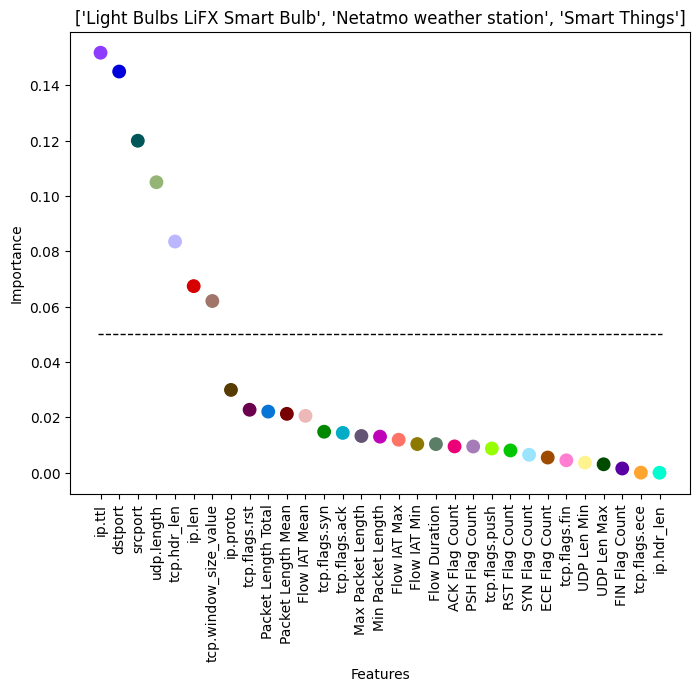

In [143]:
plot_overall_importance(overall_importance_CL1_sorted, clusters[0], 31)

In [144]:
# feat_importance_per_class_norm_df[['Smart Things']].sort_values(by='Smart Things', ascending=False)

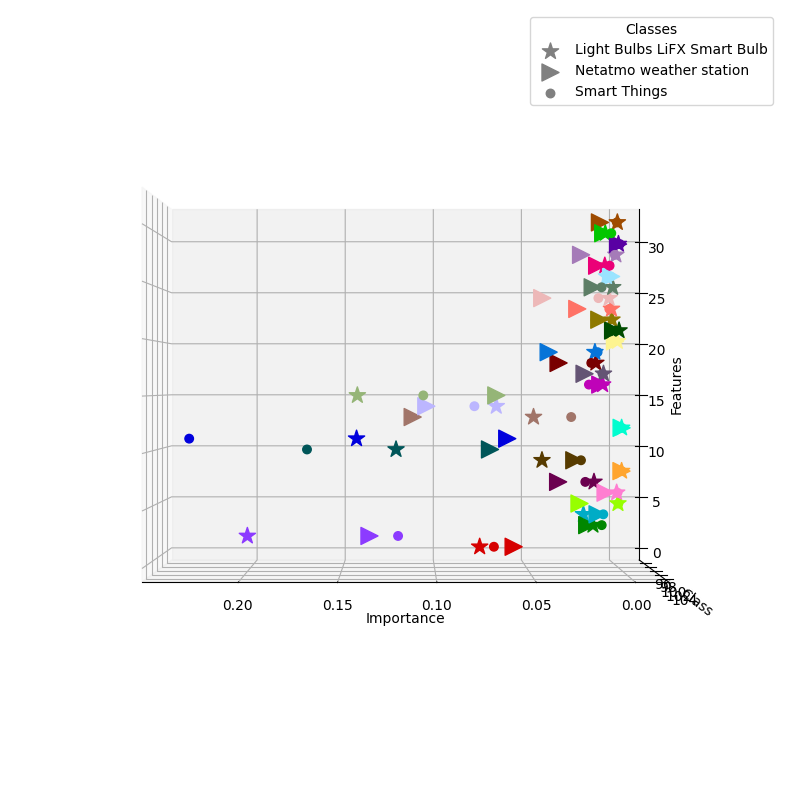

In [145]:
plot_3d_for_clusters(clusters[0], class_scores_ordered[0:3], [0,1,2], list(class_scores_ordered), classes_ordered, feat_importance_per_class_norm_df, feats_all, 31, color_lst)

In [146]:
overall_importance_CL2 = calculate_overall_importance(clusters[1], [3,4,5], feat_importance_per_class_norm_df, feats_all)
overall_importance_CL2['color'] = color_lst
overall_importance_CL2_sorted = overall_importance_CL2.sort_values(by='normalized_importance', ascending=False)

['Samsung SmartCam', 'Amazon Echo', 'Belkin wemo motion sensor']


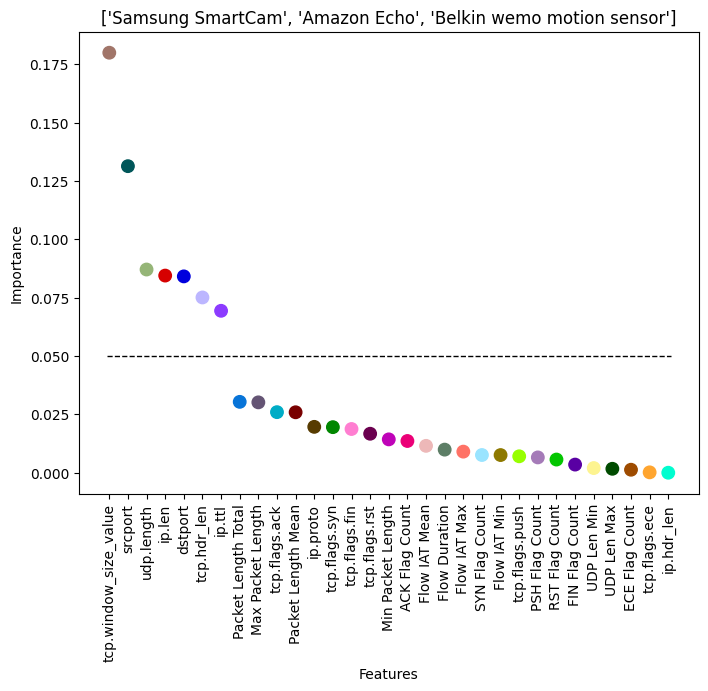

In [147]:
plot_overall_importance(overall_importance_CL2_sorted, clusters[1], 31)

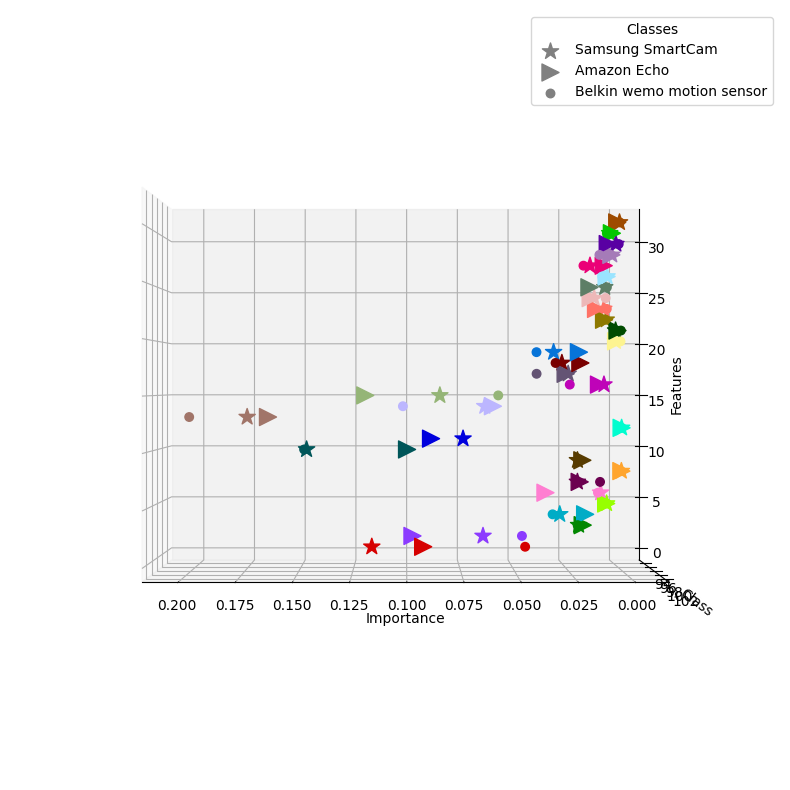

In [148]:
plot_3d_for_clusters(clusters[1], class_scores_ordered[3:6], [3,4,5], list(class_scores_ordered), classes_ordered, feat_importance_per_class_norm_df, feats_all, 31, color_lst)

In [149]:
overall_importance_CL3 = calculate_overall_importance(clusters[2], [6,7,8], feat_importance_per_class_norm_df, feature_names)
overall_importance_CL3['color'] = color_lst
overall_importance_CL3_sorted = overall_importance_CL3.sort_values(by='normalized_importance', ascending=False)

['Laptop', 'Insteon Camera', 'iHome']


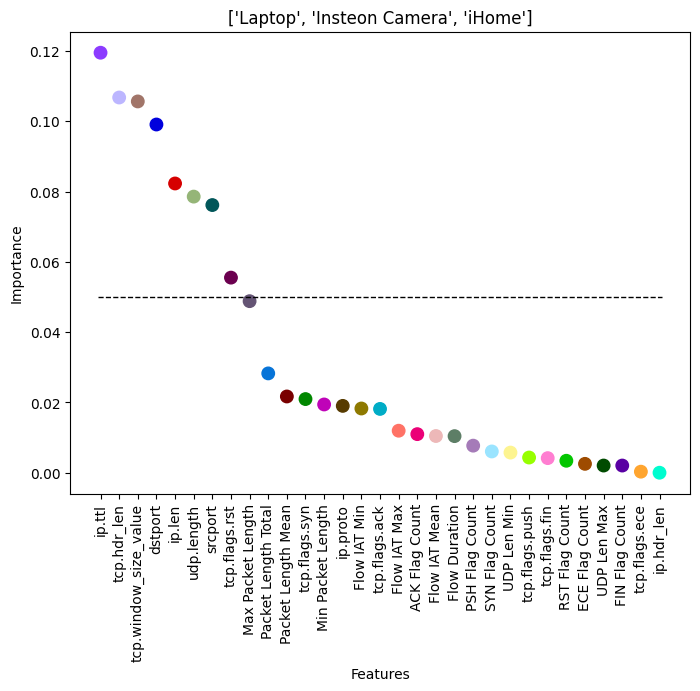

In [150]:
plot_overall_importance(overall_importance_CL3_sorted, clusters[2], 31)

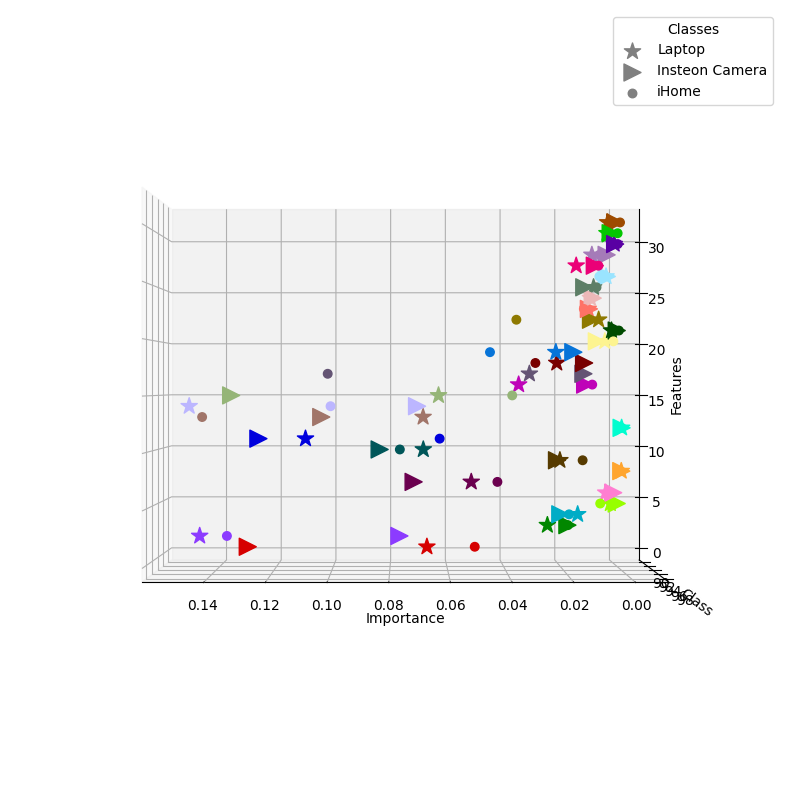

In [151]:
plot_3d_for_clusters(clusters[2], class_scores_ordered[6:9], [6,7,8], list(class_scores_ordered), classes_ordered, feat_importance_per_class_norm_df, feats_all, 31, color_lst)

#### PCFI

In [152]:
# !pip3 install shap

In [37]:
import numpy as np
import pandas as pd
import seaborn as sns
import copy as cp
import shap
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.preprocessing import scale
from sklearn.datasets import load_iris, load_wine
from matplotlib import pyplot as plt

In [38]:
def f_gini(v):
    p = v/v.sum()
    return np.multiply(p, 1-p).sum()



def f_entropy(v):
    return sps.entropy(pk=v)



def f_misclassification(v):
    p = v/v.sum()
    
def calcImportanceMatrix(rf_clf):
    """
    Calculates the importance matrix of predictors for each class.

    Arguments:
        rf_clf - The random forest classifier to calculate the importance matrix for.
        Must (?) be a RandomForestClassifier object. EXTENSIBLE TO ANY DECISION TREE CLASSIFIER FROM sklearn.tree?

    Returns:
        importance_matrix - The importance matrix with the importance of each predictor in predicting a class.
        A n by m numpy array.

    """

    # get the number of classes being predicted by the random forest
    classes = rf_clf.classes_
    n_classes = len(classes)

    # init storage for the predictor importances by classes by trees
    importance_matrix = []

    #dec_tree = rf_clf.estimators_[0]
    for dec_tree in rf_clf.estimators_:

        # get the criterion used to measure impurity
        criterion = dec_tree.get_params()['criterion']
        if criterion == 'gini':
            f_impurity = f_gini
        elif criterion == 'entropy':
            f_impurity = f_entropy
        elif criterion == 'misclassification':
            f_impurity = f_misclassification
        else:
            f_impurity = 0
            print('Unassigned impurity measure')

        # get the number of features and nodes in the tree
        feature = dec_tree.tree_.feature
        n_features = dec_tree.tree_.n_features
        n_nodes = dec_tree.tree_.__getstate__()['node_count']
        nodes = dec_tree.tree_.__getstate__()['nodes']
        parent_node_ind = -np.ones(shape=n_nodes, dtype='<i8')
        #parent_node_ind[0] = n_nodes + 1
        #print(parent_node_ind)
        for par_ind,node in enumerate(nodes):
            if node[0] != -1:
                parent_node_ind[node[0]] = par_ind
            if node[1] != -1:
                parent_node_ind[node[1]] = par_ind
        #print(parent_node_ind)

        # identify the leaves of the tree
        is_leaves = np.array([node[0]==-1 and node[1]==-1 for node in nodes])
        leaves_index = np.nonzero(is_leaves)[0]

        values_sorted = dec_tree.tree_.__getstate__()['values']
        #print ('nodes', nodes, len(nodes), len(values_sorted[:,0,:]))
        node_pred = np.argmax(values_sorted[:,0,:], axis=1)
        leaves_class_index = node_pred[is_leaves]
        #for par_ind,node in enumerate(nodes):
        #    print(par_ind,parent_node_ind[par_ind],is_leaves[par_ind],node,
        #          values_sorted[par_ind], values_sorted[par_ind].sum())
        node_unvisited = np.ones((n_classes, n_nodes), dtype=bool)
        tree_importances = np.zeros((n_classes, n_features))
        for leaf_i,leaf_c_i in zip(leaves_index,leaves_class_index):
            current_i = parent_node_ind[leaf_i]
            #print('START from leaf ', leaf_i, 'with class ', leaf_c_i)
            #print('whose parent is ', current_i)
            # walk the tree and calculate the importance of the predictor
            while current_i != -1 and node_unvisited[leaf_c_i,current_i]:
                current_node = nodes[current_i]
                left_node = nodes[current_node['left_child']]
                right_node = nodes[current_node['right_child']]
                current_feature = current_node['feature']
                
                current_values = values_sorted[current_i,0,:]
                left_values = values_sorted[current_node['left_child'],0,:]
                right_values = values_sorted[current_node['right_child'],0,:]

                current_values_class = np.array([
                    current_values[leaf_c_i],
                    current_values[np.arange(len(current_values)) != leaf_c_i].sum()
                ])
                left_values_class = np.array([
                    left_values[leaf_c_i],
                    left_values[np.arange(len(left_values)) != leaf_c_i].sum()
                ])
                right_values_class = np.array([
                    right_values[leaf_c_i],
                    right_values[np.arange(len(right_values)) != leaf_c_i].sum()
                ])
                #print(
                #    current_values,
                #    np.array([current_values[leaf_c_i],
                #              current_values[np.arange(len(current_values))!=leaf_c_i].sum()])
                #     )
                #print(current_values.sum(), left_values.sum(), right_values.sum(),
                #     left_values.sum()/current_values.sum(), right_values.sum()/current_values.sum(),
                #      current_node['weighted_n_node_samples'], left_node['weighted_n_node_samples'],
                #      right_node['weighted_n_node_samples']
                #     )
                tree_importances[leaf_c_i,current_feature] += (
                        current_node['weighted_n_node_samples'] * f_impurity(current_values_class) -
                        left_node['weighted_n_node_samples'] * f_impurity(left_values_class) -
                        right_node['weighted_n_node_samples'] * f_impurity(right_values_class)
                        )
                #print('\n', current_node, (
                #        current_node['weighted_n_node_samples'] * f_importance(current_values) -
                #        left_node['weighted_n_node_samples'] * f_importance(left_values) -
                #        right_node['weighted_n_node_samples'] * f_importance(right_values)
                #        ))
                ###
                node_unvisited[leaf_c_i,current_i] = False
                current_i = parent_node_ind[current_i]
                #print('next current is ', current_i)
        importance_matrix.append(tree_importances/nodes[0]['weighted_n_node_samples'])

    # average the predictor importances for each class by all of the trees in the forest
    importance_matrix = np.mean(importance_matrix, axis = 0)
    #normalise importance over each class
    importance_matrix = (importance_matrix.T / np.sum(importance_matrix, axis=1)).T
    return(importance_matrix)

In [39]:
rf_opt = RandomForestClassifier(max_depth = depth, n_estimators = n_tree, random_state=42, bootstrap=False,n_jobs=10)
rf_opt.fit(X_train, y_train, sample_weight=weight_of_samples)

RandomForestClassifier(bootstrap=False, max_depth=23, n_estimators=17,
                       n_jobs=10, random_state=42)

In [40]:
imp_mat = calcImportanceMatrix(rf_opt)

['Dropcam', 'HP Printer', 'Netatmo Welcome', 'Withings Smart Baby Monitor', 'Netatmo weather station', 'Smart Things', 'Amazon Echo', 'Samsung SmartCam', 'TP-Link Day Night Cloud camera', 'Triby Speaker', 'Belkin Wemo switch', 'TP-Link Smart plug', 'PIX-STAR Photo-frame', 'Belkin wemo motion sensor', 'Samsung Galaxy Tab', 'NEST Protect smoke alarm', 'Withings Smart scale', 'IPhone', 'MacBook', 'Withings Aura smart sleep sensor', 'Light Bulbs LiFX Smart Bulb', 'Blipcare Blood Pressure meter', 'iHome', 'Insteon Camera', 'Android Phone', 'Laptop']


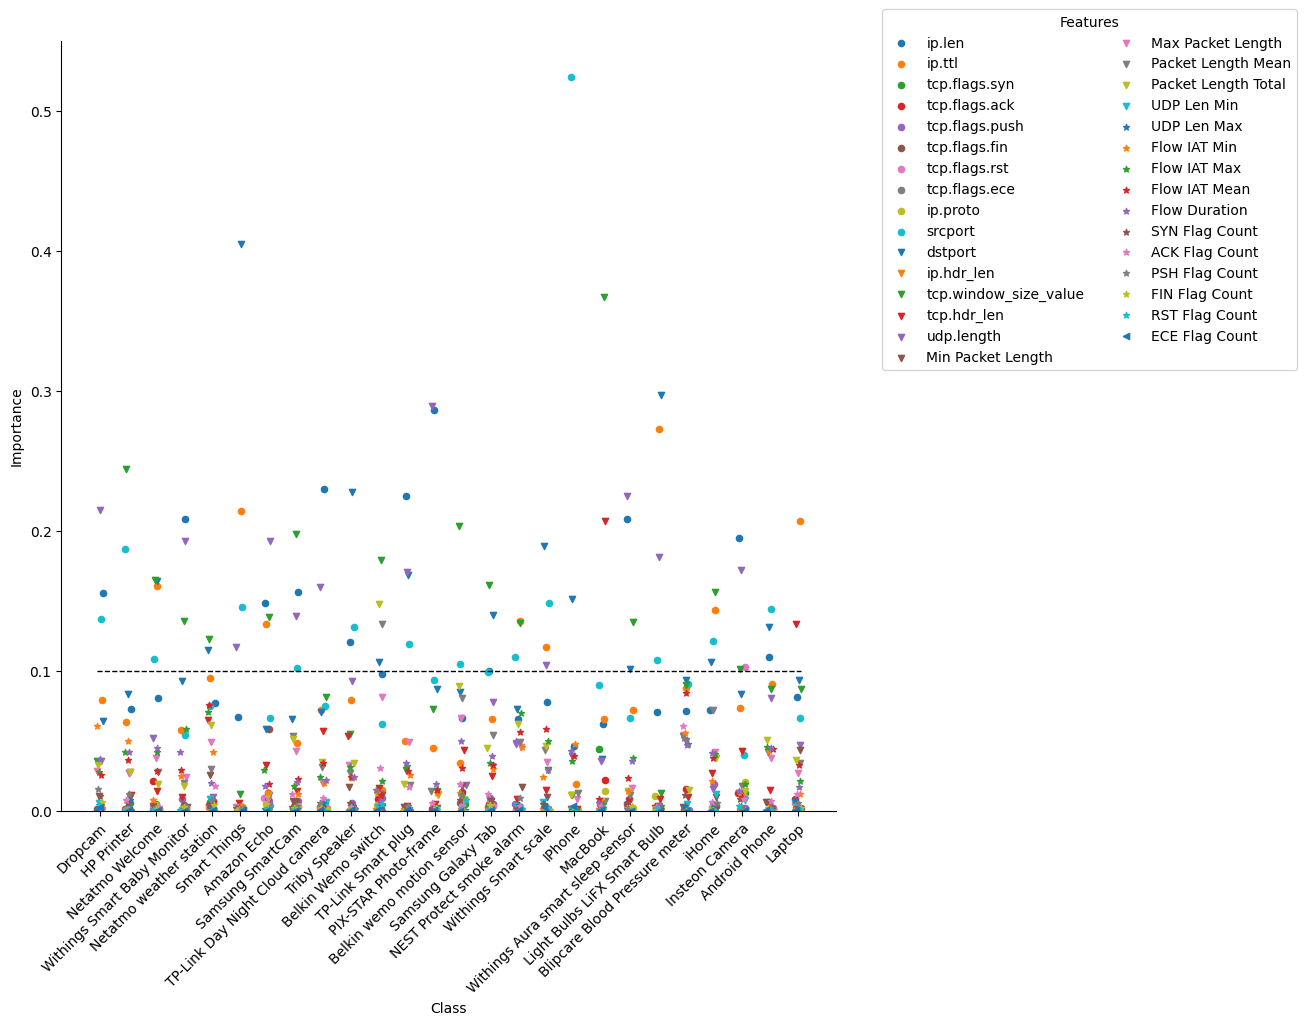

In [30]:
#importance distribution over classes
# imp_mat = calcImportanceMatrix(rf_opt)

marker_lst = [
    "o", "v", "*", "<"
]
color_lst = sns.color_palette(n_colors=10)
# print(len(color_lst))
color_marker_lst = [(c,m) for m in marker_lst for c in color_lst]

feature_names = feats_all
class_names = classes
len_class_names = len(class_names)
print(class_names)
fig, ax = plt.subplots(figsize=(10,10))
for j in np.arange(len(feature_names)):
    ax.scatter(np.arange(len_class_names) + np.random.uniform(-1,1,size=len_class_names)*.25/2.,
               imp_mat[:,j], color=color_marker_lst[j][0], marker=color_marker_lst[j][1],
               s=20, label=feature_names[j])
ax.hlines(y=0.1, xmin=-.25/2., xmax=len(class_names)-1+.25/2., colors='k', linestyles='dashed', lw=1)
ax.legend(bbox_to_anchor=(1.05, 1.05), title='Features', ncol=2)
ax.set_xticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names, rotation=45, ha='right', rotation_mode='anchor')
ax.set_xlabel('Class')
ax.set_ylabel('Importance')
ax.set_ylim(bottom=0)
sns.despine(fig=fig)
#fig.savefig(fig_path+'/feature_importance_distribution_in_classes.pdf', bbox_inches='tight')
plt.show()
plt.close()

##### Test!

In [15]:
# list of 8 applications in dataset
classes = ['Netatmo weather station', 'Smart Things', 'Light Bulbs LiFX Smart Bulb', 'Other']
classes_df = pd.DataFrame(classes, columns=['class'])

feats_important = ['dstport', 'ip.ttl', 'udp.length', 'srcport', 'tcp.window_size_value', 'ip.len']

In [21]:
# Load Train and Test data
time = "normal"
npkts = 3
feats_to_use = feats_all
if(time=="normal"):
    train_data = pd.read_csv("/home/nds-admin/UNSW_PCAPS/train/train_data_hybrid/train_data_"+str(npkts)+".csv")
    test_data = pd.read_csv("/home/nds-admin/UNSW_PCAPS/test/csv_files/16-10-05.pcap.txt_"+str(npkts)+"_pkts.csv")
#
flow_pkt_counts = pd.read_csv("/home/nds-admin/UNSW_PCAPS/hyb_code/16-10-05-flow-counts.csv")
#
### FIX ###
flow_count_dict = flow_pkt_counts.set_index("flow.id")["count"].to_dict()
# Map the values from flow_pkt_counts to test_data based on the "Flow ID" column
test_data["pkt_count"] = test_data["Flow ID"].map(flow_count_dict)
###########

#### To get packet count of each flow in train data
packet_data = pd.read_csv("/home/nds-admin/UNSW_PCAPS/train/train_data_hybrid/UNSW_train_ALL_PKT_DATE.csv")
packet_data = packet_data[['Flow ID', 'packet_count', 'File']]
packet_data['File_ID'] = packet_data['Flow ID'] + ' ' + packet_data['File']
packet_data = packet_data.drop_duplicates(subset='File_ID', keep='first')
train_data['File_ID'] = train_data['Flow ID'] + ' ' + train_data['File']

flow_count_dict_train = packet_data.set_index("File_ID")["packet_count"].to_dict()
# Map the values from flow_pkt_counts to test_data based on the "Flow ID" column
train_data["pkt_count"] = train_data["File_ID"].map(flow_count_dict_train)
###########

In [22]:
all_minus_one = (test_data['Min Packet Length'] == -1) & (test_data['Max Packet Length'] == -1) & (test_data['Packet Length Mean'] == -1)
# Assign values to the multiply column based on the conditions
test_data['multiply'] = np.where(all_minus_one, 1, test_data['pkt_count'] - npkts)

train_data = train_data.sample(frac=1, random_state=42)
test_data  = test_data.sample(frac=1, random_state=42)

train_data = train_data.dropna(subset=['srcport', 'dstport']) 
test_data  = test_data.dropna(subset=['srcport', 'dstport'])

####
train_data['Label_NEW'] = np.where((train_data['Label'].isin(['Netatmo weather station', 'Smart Things', 'Light Bulbs LiFX Smart Bulb'])), train_data['Label'], 'Other')
test_data['Label_NEW'] = np.where((test_data['Label'].isin(['Netatmo weather station', 'Smart Things', 'Light Bulbs LiFX Smart Bulb'])), test_data['Label'], 'Other')
print(train_data['Label_NEW'].value_counts())
print(test_data['Label_NEW'].value_counts())
####

test_labels, test_indices = get_test_labels(test_data)
print("Num Labels: ", len(test_labels))

Label_NEW
Other                          1363533
Light Bulbs LiFX Smart Bulb      30621
Smart Things                     13953
Netatmo weather station          11068
Name: count, dtype: int64
Label_NEW
Other                          138876
Light Bulbs LiFX Smart Bulb      1735
Netatmo weather station           744
Smart Things                      598
Name: count, dtype: int64
Num Labels:  4


In [23]:
print(test_labels)
print(test_indices)

['Other' 'Light Bulbs LiFX Smart Bulb' 'Netatmo weather station'
 'Smart Things']
[3, 2, 0, 1]


In [24]:
train_data['sample_nature'] = train_data.apply(assign_sample_nature, axis=1)
test_data['sample_nature']  = test_data.apply(assign_sample_nature, axis=1)

train_data['weight'] = np.where(train_data['sample_nature'] == 'flw', (train_data['pkt_count'] - npkts + 1)/train_data['pkt_count'], 1/train_data['pkt_count'])
weight_of_samples = list(train_data['weight'])


# Get Variables and Labels
y_multiply = test_data['multiply'].astype(int)
test_flow_pkt_cnt = test_data['pkt_count'].to_list()
test_flow_IDs = test_data['Flow ID'].to_list()
X_train, y_train, sample_nat_train = get_x_y_flow(train_data, feats_to_use)
X_test,  y_test, sample_nat_test  = get_x_y_flow(test_data, feats_to_use)

In [25]:
### ALL WITH MDI-BASED
rf_opt = RandomForestClassifier(max_depth = 15, n_estimators = 1, random_state=42, max_leaf_nodes=500, bootstrap=False, n_jobs=10)
rf_opt.fit(X_train, y_train, sample_weight=weight_of_samples)
feature_importance = pd.DataFrame(rf_opt.feature_importances_)
feature_importance.index = X_train.columns
feature_importance = feature_importance.sort_values(by=list(feature_importance.columns),axis=0,ascending=False)

In [26]:
feature_importance

,0
dstport,3.401906e-01
srcport,2.338482e-01
ip.ttl,1.349020e-01
ip.len,1.232832e-01
tcp.flags.rst,4.602510e-02
udp.length,3.737596e-02
Flow Duration,2.308947e-02
tcp.flags.ack,1.748421e-02
Packet Length Total,9.341705e-03
Max Packet Length,8.528831e-03


In [66]:
model, c_report, macro_f1, weight_f1, y_pred = get_scores(classes, 15, 1, ['dstport', 'ip.ttl', 'udp.length', 'srcport'], 500, X_train, y_train, X_test, y_test, test_indices, test_labels, weight_of_samples)

RandomForestClassifier(bootstrap=False, max_depth=15, max_leaf_nodes=500,
                       n_estimators=1, n_jobs=10, random_state=42)


In [67]:
model

RandomForestClassifier(bootstrap=False, max_depth=15, max_leaf_nodes=500,
                       n_estimators=1, n_jobs=10, random_state=42)

In [68]:
pkt_macro_f1, pkt_weighted_f1, flw_macro_f1, flw_weighted_f1 = compute_flow_pkt_scores(y_pred, y_test, sample_nat_test, test_indices, test_labels)
                            

In [69]:
print(pkt_macro_f1, pkt_weighted_f1, flw_macro_f1, flw_weighted_f1)

0.9971428832921914 0.9998387078027288 0.9939247974774019 0.9998357919728664


In [70]:
num_samples, macro_f1_PL, weighted_f1_PL, micro_f1_PL, cl_report_PL, macro_f1_FL, weighted_f1_FL, micro_f1_FL, cl_report_FL = expand_rows_and_get_scores(y_test, y_pred, sample_nat_test, y_multiply, test_flow_pkt_cnt, test_flow_IDs, test_indices, test_labels)

In [71]:
print(macro_f1_FL, weighted_f1_FL, micro_f1_FL)

0.9966846972111866 0.9997957827495002 0.9997956381469641


In [72]:
cl_report_FL

{'Other': {'precision': 0.9999149811695159,
  'recall': 0.999872491121725,
  'f1-score': 0.9998937356942215,
  'support': 58813.00000000916},
 'Light Bulbs LiFX Smart Bulb': {'precision': 0.998674618952948,
  'recall': 0.9986746189529474,
  'f1-score': 0.9986746189529477,
  'support': 1508.9999999998954},
 'Netatmo weather station': {'precision': 0.9880032420122895,
  'recall': 0.995967741935483,
  'f1-score': 0.9919695055356925,
  'support': 247.9999999999996},
 'Smart Things': {'precision': 0.995780590717302,
  'recall': 0.9966216216216235,
  'f1-score': 0.9962009286618848,
  'support': 592.0000000003295},
 'accuracy': 0.9997956381469641,
 'macro avg': {'precision': 0.9955933582130139,
  'recall': 0.9977841184079448,
  'f1-score': 0.9966846972111866,
  'support': 61162.000000009386},
 'weighted avg': {'precision': 0.9997960613002588,
  'recall': 0.9997956381469214,
  'f1-score': 0.9997957827495002,
  'support': 61162.000000009386}}

In [ ]:
0.9922074637511771;0.9994689459347016;0.9994686377219225